In [3]:
## Exploring Poetic Form through Geometry

import json 
import pandas as pd
import re
import requests
import drawSvg as draw


/usr/local/lib/python3.6/site-packages/drawSvg/raster.py:11: RuntimeWarning: CairoSVG will need to be installed to rasterize images: Install with `pip3 install cairosvg`
  warnings.warn(msg, RuntimeWarning)


In [4]:
## need to think about how to deal with caesuras and/or spaces

## next steps
# - colors related to themes? or positions?
# - dynamically generate some kind of css box
# - filter with same options as american academy website
# - link back to poem a day site
# - somehow set up daily job to scrape and update unclear how that works
# - what does this teach you page
# - put in your own poem section
# - programmatically overlay files
# - most geometrically similar forms??

In [5]:
## utils ##

colors = pd.read_csv('colors.csv')['colors'].to_list()

def remove_html(data):
    p = re.compile(r'<.*?>')
    return p.sub('', data)

In [6]:
with open('../data/theme_poems.json', 'r') as f:
    poems = json.load(f)
    raw_poems = pd.DataFrame(poems)

In [7]:
# need to format poems such that multiple instances are themed together
# remove audio only

In [8]:
def clean_poems_df(df):
    df = df.loc[df.theme_id!=896] # removing audio category, thereby also removing audio only
    
    df = df.loc[~df.view_node.isnull()] # remove blanks
    
    df['author'] = [remove_html(str(x)) for x in df['field_author']]
    
    themes_agg = df[['view_node','theme_id']].groupby('view_node').aggregate(lambda x: list(x))

    df = df.drop(columns=['headers','index','page','theme_id','field_author','content'])
    
    df = df.drop_duplicates()
    
    df = df.merge(themes_agg, how = 'left', on='view_node')
 
    df['first_theme'] = [x[0] for x in df['theme_id']] # this prioritizes alphabetically :(
    
    return df
    
poems_df = clean_poems_df(raw_poems)

In [9]:
poems_df.head(10)

,body,field_date_published,title,view_node,author,theme_id,first_theme
0,<p>It is rare that I<br />have to stop eating...,2018,Amuse-Bouche,/poem/amuse-bouche,Max Ritvo,"[851, 971, 1011]",851
1,<p><em>for Maria Jesus Martinez</em></p><p>Yo...,2018,Where Love Is Ground to Wheat,/poem/where-love-ground-wheat,J. Michael Martinez,"[851, 971]",851
2,<pre>The cataract whirling down the precipice...,1920,Fragment,/poem/fragment-1,John Clare,[851],851
3,<pre>If I had a million lives to live\n \tan...,1919,Humdrum,/poem/humdrum,Carl Sandburg,"[851, 856, 971]",851
4,<pre>No matter how he wrested himself silent ...,2018,Leaving,/poem/leaving-0,Allison Adelle Hedge Coke,"[851, 971, 1021, 1076]",851
5,<pre>I kissed a kiss in youth\n Upon a dead...,1922,Scintilla,/poem/scintilla,William Stanley Braithwaite,"[851, 971]",851
6,"<p><span class=""long-line"">Come find me under...",2018,The Dying Girl &amp; The Date Palm,/poem/dying-girl-date-palm,Jennifer Givhan,"[851, 971]",851
7,<pre>As due by many titles I resign\nMyself t...,2018,As due by many titles I resign (Holy Sonnet II),/poem/due-many-titles-i-resign-holy-sonnet-ii,John Donne,[851],851
8,<pre>Can’st thou conjure a vanished morn of s...,1903,Aftermath,/poem/aftermath-1,Willa Cather,"[851, 856, 901]",851
9,<pre>One morning the spirit of my lover’s unc...,2018,XI,/poem/xi,Ruben Quesada,"[851, 971, 1066]",851


In [10]:
def get_theme_list():
    r = requests.get("https://api.poets.org/api/taxonomy_term/themes")
    themes_raw = r.json()['data']
    return {t['attributes']['drupal_internal__tid']: t['attributes']['name'] for t in themes_raw}

In [11]:
themes = get_theme_list()

In [12]:
theme_colors = {t: colors[i] for i,t in enumerate(themes)}

In [93]:
def clean_poem(text):
    if '<p>' in text or '<pre>' in text:
        text = text.strip()
        text_arr = []
        for delimiter in ['<br />','<br />','\n']:
            if delimiter in text:
                text_arr = text.split(delimiter)
        return [remove_html(t) for t in text_arr]
    else:
        return text.split("\n")

def draw_rect(x, y, chars, color):
    return draw.Rectangle(x*5, y, chars*5, 10, fill = color)

def fill_rect(y, width): 
    return draw.Rectangle(0, y, width, 10, fill = '#ffffff')

def get_params(arr):
    num_lines = len(arr)

    orig_lens = [len(x) for x in arr]
    max_len = max(orig_lens)
    leading = [max((len(a) - len(a.lstrip())), (a.count('\xa0'))) for a in arr]
    new_arr = [a.replace('\xa0','') for a in arr]
    lens = [len(x.strip()) for x in new_arr]
    
    fill_width = 350
    if max_len > 70:
        fill_width = 700
#    if max_len > 140:
#        print("exceeded at: ", max_len)
    
    return num_lines, max_len, leading, lens, fill_width
    

def draw_poem(text, spacing=2, color='#a6cee3', name='test2.svg'):
    #print(text)
    text_array = clean_poem(text)
    num_lines, max_len, leading, lens, fill_width = get_params(text_array)
    #print(max_len)
    ht = (num_lines * (10 + spacing)) + 20
    #d = draw.Drawing(5*max_len, ht, origin=(0,-ht + 20))

    d = draw.Drawing(fill_width, ht, origin=(0,-ht + 20))
    for i, l in enumerate(lens):
        x = leading[i]
        y = i*(-10-spacing)
        d.append(fill_rect(y, fill_width))
        d.append(draw_rect(x, y, l, color))
    d.saveSvg(name)
    return d

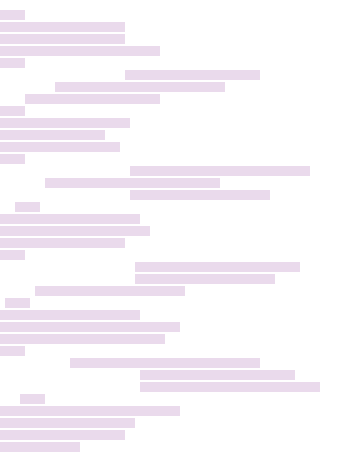

In [94]:
sample = poems_df.sample(1)
draw_poem(sample['body'].tolist()[0], color=theme_colors[sample['first_theme'].tolist()[0]])


In [15]:
poems_df.sample(10)

,body,field_date_published,title,view_node,author,theme_id,first_theme
814,"<p>Lord, I ain’t asking to be the Beastmaster...",2017,A Prayer to Talk to Animals,/poem/prayer-talk-animals,Nickole Brown,[886],886
810,<pre>\nLet’s talk about\nyour long-lost lion ...,2017,Note from My Mother,/poem/note-my-mother,Jeff Hoffman,"[886, 936]",886
3890,<p>I won’t ever tell you how it ended.<br />B...,2016,Washington Mews,/poem/washington-mews,Rowan Ricardo Phillips,[1086],1086
2999,<pre>&#13;\na party. Everybody&#13;\nat home ...,2013,I Love the Hour Just Before,/poem/i-love-hour-just,Todd Boss,"[996, 1046]",996
301,"<pre>\nThere was a time when meadow, grove, a...",1807,Ode on Intimations of Immortality from Recolle...,/poem/ode-intimations-immortality-recollection...,William Wordsworth,"[856, 901, 936]",856
55,<pre>\nThis is the moment when you see again\...,2006,The Night Migrations,/poem/night-migrations,Louise Glück,[851],851
1665,<p> ...,2018,Cross/Bite,/poem/crossbite,Tiana Clark,[916],916
862,"<p>The heart's reasons<br />seen clearly,<br ...",1994,The Weighing,/poem/weighing,Jane Hirshfield,[886],886
3092,<pre>\nEarth took of earth earth with ill;\nE...,1000,Earth Took of Earth,/poem/earth-took-earth,Anonymous,[1006],1006
1024,<pre>\nFor I will consider my Cat Jeoffry.\nF...,1939,"Jubilate Agno, Fragment B, [For I will conside...",/poem/jubilate-agno-fragment-b-i-will-consider...,Christopher Smart,[886],886


,body,field_date_published,title,view_node,author,theme_id,first_theme
1184,"<p> Behold the dread Mt. Shasta, where it...",2017,Mount Shasta,/poem/mount-shasta,John Rollin Ridge,[901],901


In [67]:
def get_all(data):
    
    link = 'https://poets.org' + data['view_node']
    file = data['view_node'].replace('/poem/','') + '.svg'
    title = data['title']
    grp = ', '.join(["\"" + str.lower(themes[i]) + "\"" for i in data['theme_id']])
    year = data['field_date_published']
    author = remove_html(data['author'])
        
    # save drawing?? 
    
    text = data['body']
    
    
    fill_width = draw_poem(text, color = theme_colors[data['first_theme']], name = '../img/'+file)
    
    if fill_width == 350:
        fig = "col-3@xs col-4@sm col-3@md picture-item"
    else:
        fig = "col-6@xs col-8@sm col-6@md picture-item picture-item--overlay"
    
    
    # return html
    html = """
        <figure class="{fig}" data-groups='[{grp}]' data-date-created="{year}-01-01" data-title="{file}">
          <div class="picture-item__inner">
        <!-- <div class="aspect aspect--16x9"> -->
          <!-- <div class="aspect__inner"> -->
                <img src="img/{file}" srcset="img/{file} 1x, img/{file} 2x"
                  alt="{title}" />
          <!-- </div> -->
        <!-- </div> -->
            <div class="picture-item__details">
              <figcaption class="picture-item__title"><a href="{link}" target="_blank" rel="noopener">{title}</a></figcaption>
              <p class="picture-item__tags hidden@xs">{author}</p>
            </div>
          </div>
        </figure>
    """.format(fig=fig, grp=grp, year=year, file=file, link=link, title = title, author=author)
    
   
    return html

In [64]:
def do_all(df, file):
    with open(file, "w") as f:
        for i in range(0,len(df)):
            try:
                f.write(get_all(df.iloc[i])+ '\n')
            except:
                print('exception at poem ', i)

In [70]:
do_all(poems_df.sample(10), '../data/poems_html.txt')

In [68]:
get_all(sample.iloc[0])

'\n        <figure class="col-3@xs col-4@sm col-3@md picture-item" data-groups=\'["beauty"]\' data-date-created="2017-01-01" data-title="mount-shasta.svg">\n          <div class="picture-item__inner">\n        <!-- <div class="aspect aspect--16x9"> -->\n          <!-- <div class="aspect__inner"> -->\n                <img src="img/mount-shasta.svg" srcset="img/mount-shasta.svg 1x, img/mount-shasta.svg 2x"\n                  alt="Mount Shasta" />\n          <!-- </div> -->\n        <!-- </div> -->\n            <div class="picture-item__details">\n              <figcaption class="picture-item__title"><a href="https://poets.org/poem/mount-shasta" target="_blank" rel="noopener">Mount Shasta</a></figcaption>\n              <p class="picture-item__tags hidden@xs">John Rollin Ridge</p>\n            </div>\n          </div>\n        </figure>\n    '

In [72]:
poems_df.sample(10).to_csv('test.csv')

In [131]:
def get_info(data):
    
    file = data['view_node'].replace('/poem/','') + '.svg'

    # save drawing?? 
    
    text = data['body'] 
    text_array = clean_poem(text)
    num_lines, max_len, _, _, fill_width = get_params(text_array)
    
    if fill_width == 350:
        fig = "col-3@xs col-4@sm col-3@md picture-item"
    else:
        fig = "col-6@xs col-8@sm col-6@md picture-item picture-item--overlay"


    info = {
        "short_name" : data['view_node'].replace('/poem/',''),
        "title" : data['title'],
        "grp" : ', '.join(["\"" + str.lower(themes[i]) + "\"" for i in data['theme_id']]),
        "year" : data['field_date_published'],
        "author" : remove_html(data['author']),
        "fig" : fig,
        "num_lines" : num_lines,
        "max_len" : max_len
    }
           
    return pd.Series(info)

In [134]:
def get_json(df, file):
    out_df = pd.DataFrame()
    for i in range(0,len(df)):
        try:
            out_df = out_df.append(get_info(df.iloc[i]), ignore_index=True)
        except:
            print("Exception at poem ", i)
    out_df = out_df.sample(frac=1).reset_index(drop=True) #randomize order - eventually replace with groups?
    out_df.to_csv(file, index=False)


In [133]:
get_json(poems_df, '../data/poems_info.csv')

Exception at poem  21
Exception at poem  36
Exception at poem  66
Exception at poem  86
Exception at poem  111
Exception at poem  164
Exception at poem  200
Exception at poem  239
Exception at poem  272
Exception at poem  330
Exception at poem  377
Exception at poem  407
Exception at poem  414
Exception at poem  465
Exception at poem  508
Exception at poem  522
Exception at poem  535
Exception at poem  538
Exception at poem  546
Exception at poem  562
Exception at poem  582
Exception at poem  640
Exception at poem  651
Exception at poem  682
Exception at poem  686
Exception at poem  714
Exception at poem  723
Exception at poem  783
Exception at poem  803
Exception at poem  805
Exception at poem  892
Exception at poem  896
Exception at poem  939
Exception at poem  943
Exception at poem  944
Exception at poem  977
Exception at poem  982
Exception at poem  986
Exception at poem  1011
Exception at poem  1193
Exception at poem  1244
Exception at poem  1245
Exception at poem  1247
Exception 

In [114]:
get_info(poems_df.iloc[0])

short_name                                         amuse-bouche
title                                              Amuse-Bouche
grp                              "afterlife", "death", "eating"
year                                                       2018
author                                                Max Ritvo
fig           col-6@xs col-8@sm col-6@md picture-item pictur...
num_lines                                                    14
max_len                                                      71
dtype: object